In [1]:
#DSCI 100 Group Project

**Introduction:** 

Our group project will be utilizing the Heart Disease dataset. This dataset tracks various risk factors that individuals with heart disease have, such as: 

(1) Age: age of the patient. 

(8) Maximum Heart Rate of the patient (thalach): measures the fastest recorded rate of the patient's heart in beats per minute (bpm). 

(14) Diagnosis of heart disease (num): states whether the patient was given the status of having an angiographic disease. 
    0 = no heart disease
    1, 2, 3, 4 = heart disease

This data can have a tremendous impact on the ability to diagnose heart disease and identify risk factors in individuals who have not yet presented with heart disease. Our group will be answering the predictive question: Can we predict a diagnosis of heart disease based on an individual's age and cholesterol levels?

In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
library(dplyr)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [14]:
cleveland_data <- read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", 
                           col_names = c("age", "sex", "cp", "trestbps", 
                                         "chol", "fbs", "restecg", "thalach", 
                                         "exang", "oldpeak", "slope", "ca", "thal", "num")) 
cleveland_data <- cleveland_data |>
    mutate(num = as_factor(num)) |>
    mutate(num = case_when(num %in% c(1, 2, 3, 4) ~ "1", num %in% 0 ~ "0"))

cleveland_data_reduced <- cleveland_data |>
    select(age, thalach, num)

cleveland_data_reduced

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,thalach,num
<dbl>,<dbl>,<chr>
63,150,0
67,108,1
67,129,1
⋮,⋮,⋮
57,115,1
57,174,1
38,173,0


In [15]:
set.seed(2002) #do not change this!!!

cleveland_split <- initial_split(cleveland_data_reduced, prop = 0.75, strata = num)
cleveland_training <- training(cleveland_split)
cleveland_testing <- testing(cleveland_split)

summary_table <- cleveland_training |>
    summarize(age_mean = mean(age, na.rm = TRUE), thalach_mean = mean(thalach, na.rm = TRUE),
             age_sd = sd(age, na.rm = TRUE), thalach_sd = sd(thalach, na.rm = TRUE))
summary_table

age_mean,thalach_mean,age_sd,thalach_sd
<dbl>,<dbl>,<dbl>,<dbl>
54.33921,148.9515,8.70329,22.24606


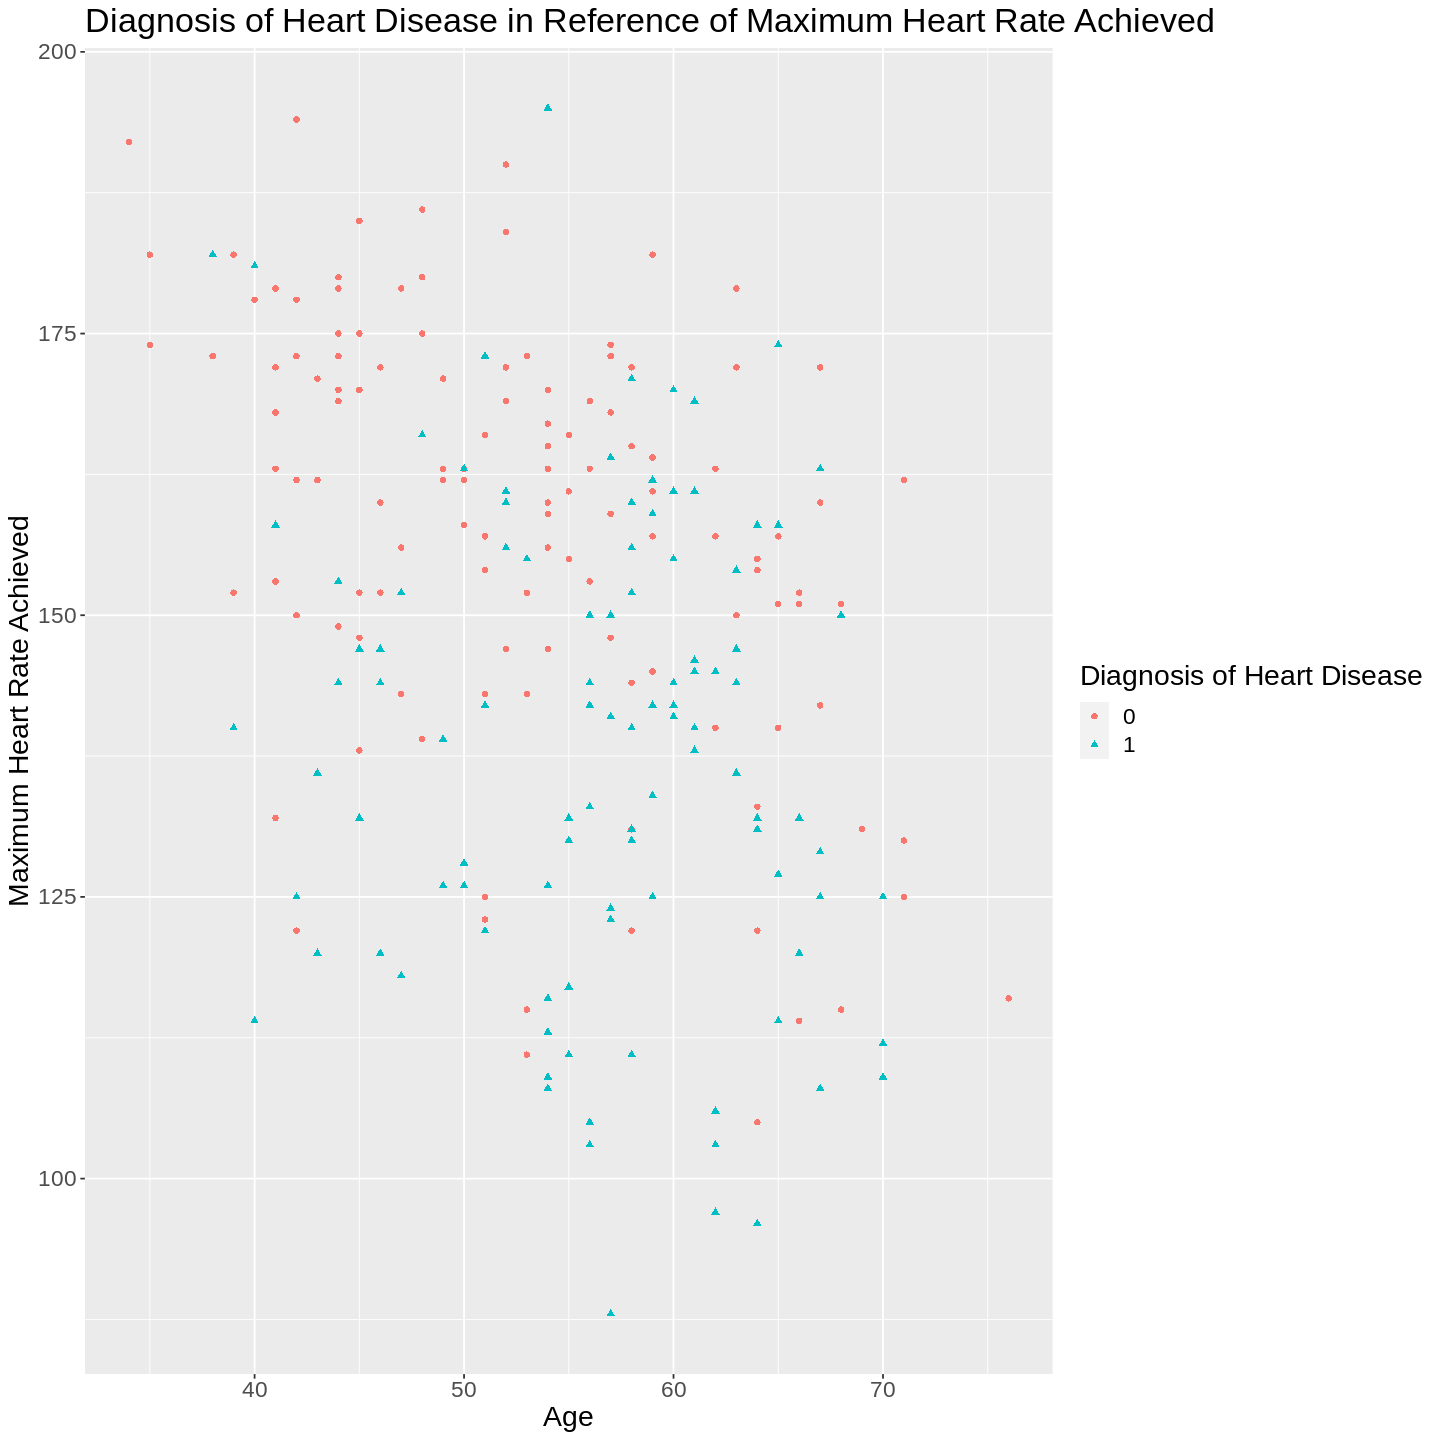

In [16]:
options(repr.plot.width = 12, repr.plot.height = 12)

plot <- cleveland_training |>
    ggplot(aes(x = age, y = thalach, color = num, shape = num)) +
    geom_point() + 
    labs(x = "Age", y = "Maximum Heart Rate Achieved", color = "Diagnosis of Heart Disease", shape = "Diagnosis of Heart Disease") +
    ggtitle("Diagnosis of Heart Disease in Reference of Maximum Heart Rate Achieved") +
    theme(text = element_text(size = 17))
plot

**Commentary:** The first table is reduced version of the dataset, containing only the values that we will be unsing during this analysis; age, thalach, and num. The second table is a summary table that depicts the mean age and mean heart rate of the individual observations in the dataset, as well as the standard deviation of the age and heart rate. This gives us an idea of the shape of our dataset. The graph is a scatterplot of maximum heart rate vs age, with the diagnosis of heart disease displayed via colour and shape. As can be seen in the graph, the relationship between heart rate and age appears to be linear and not strong. Furthermore, there doesn't appear to be a strong relationship between heart rate and heart disease diagnosis, or age and heart disease diagnosis. 


**Method**: To complete our data analysis, we will be using K -nearest neighbors classification. Through cross-validation of the training dataset, we will choose the optimal K. which we will use to train our data. The class that we will be predicting is the variable num, an integer-valued from 0 (no presence) to 4, which gives the diagnosis of heart disease based on angiographic disease status. The variables that we will use to predict the class are age (in years), and cholesterol levels. We will then use the testing data set to evaluate the accuracy of our model. If the accuracy is above 80% accuracy, then our chosen variable of age and cholesterol levels will be a significant contributor to the diagnosis of heart disease. 


**Expected Outcomes and Significance**: Individuals with a higher age range have a higher risk of having heart disease. By conducting data analysis, it will be helpful in assisting the diagnosis of heart disease. Having a classification model which predicts heart diseases based on age and cholesterol can greatly reduce the medical resources used to formally diagnose such diseases, for example, if the model indicates a 99% chance of negative on a patient, and without other symptoms present, it could be an indication that the patient is healthy. Furthermore, the model can be used as an indicator for patients to receive formal medical attention and formal medical treatment, which could help with an early-stage diagnosis of certain heart diseases, and treat those diseases in a time-efficient manner. As seen in the data set, it could lead to discovering more factors that could result in heart diseases, such as cholesterol levels, smoking, history of diabetes and coronary heart disease, and more. 
